# Traffic detect 

This notebook contains an initial attempt of detecting traffic using yolov8n. Note the model from ultralytics has not been pretrained yet. 

Todo
- annotate data
- create scripts to perform spot checks throughout the day 
- Train yolov8n to do the prediction to improve results 
- Verify is noise present at 2 minute interval is from the model or inherit to traffic conditions
- Build custom detection model with a pretrained backbone
- Compare the performance across yolov8n and custom model 

## Packages

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
from datetime import datetime
import os 
from ultralytics import YOLO
import cv2

## Constants

In [142]:
SEED=53456

# setting up the paths
cwd=os.getcwd()
root = os.path.dirname(cwd)
image_folder = os.path.join(root, 'dat','processed_images','147','2024-10-29')
annotate_folder = os.path.join(root, 'dat','annotate','147','2024-10-29')
os.makedirs(annotate_folder, exist_ok=True)
image_file_path = os.path.join(image_folder, 'traffic_202410290738.jpg')

## Object detection: YOLOv8n

In [ ]:
# Load a model
model = YOLO("yolov8n.pt")  # pretrained YOLO11n model

### Single image detection 

In [61]:
# Run batched inference on a list of images
image_paths = [image_file_path]
results = model(image_paths)  # return a list of Results objects

# Process results list
for result in results:
    boxes = result.boxes  # Boxes object for bounding box outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs
    obb = result.obb  # Oriented boxes object for OBB outputs
    result.show()  # display to screen
    result.save(filename="result.jpg")  # save to disk

0: 480x640 16 cars, 1 bus, 1 truck, 512.1ms
Speed: 48.8ms preprocess, 512.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


In [68]:
result.show()  # display to screen

### Detect images in a day

In [117]:
# Run batched inference on a list of images
image_paths = [os.path.join(image_folder, file) for file in os.listdir(image_folder)]
results = model(image_paths)  # return a list of Results objects

num_cars = []
# Process results list
for result in results:
    boxes = result.boxes  # Boxes object for bounding box outputs
    num_cars.append(len(boxes.cls))
    #result.show()  # display to screen
    #result.save(filename="result.jpg")  # save to disk


0: 448x640 1 car, 96.1ms
1: 448x640 1 car, 96.1ms
2: 448x640 1 car, 96.1ms
3: 448x640 2 cars, 96.1ms
4: 448x640 1 car, 96.1ms
5: 448x640 1 car, 96.1ms
6: 448x640 1 car, 96.1ms
7: 448x640 1 car, 1 train, 96.1ms
8: 448x640 1 person, 1 car, 96.1ms
9: 448x640 1 car, 96.1ms
10: 448x640 1 car, 96.1ms
11: 448x640 1 car, 96.1ms
12: 448x640 1 car, 1 train, 96.1ms
13: 448x640 1 car, 96.1ms
14: 448x640 2 cars, 96.1ms
15: 448x640 1 car, 96.1ms
16: 448x640 1 car, 96.1ms
17: 448x640 3 cars, 96.1ms
18: 448x640 2 cars, 96.1ms
19: 448x640 1 car, 96.1ms
20: 448x640 1 car, 96.1ms
21: 448x640 1 car, 96.1ms
22: 448x640 1 car, 96.1ms
23: 448x640 3 cars, 96.1ms
24: 448x640 1 car, 96.1ms
25: 448x640 1 car, 1 train, 96.1ms
26: 448x640 1 car, 96.1ms
27: 448x640 1 car, 96.1ms
28: 448x640 1 car, 96.1ms
29: 448x640 1 car, 96.1ms
30: 448x640 1 car, 96.1ms
31: 448x640 1 car, 96.1ms
32: 448x640 1 car, 96.1ms
33: 448x640 1 car, 1 train, 96.1ms
34: 448x640 1 car, 96.1ms
35: 448x640 1 car, 96.1ms
36: 448x640 1 car, 96.

### Plot results

It appears that with yolov8n the counts are very noisy. However, when aggregating to every 30 minutes by taking mean the trend is more clear. Should verify if noise seen in the plot at higher resolution is from the model or inherit to traffic conditions.

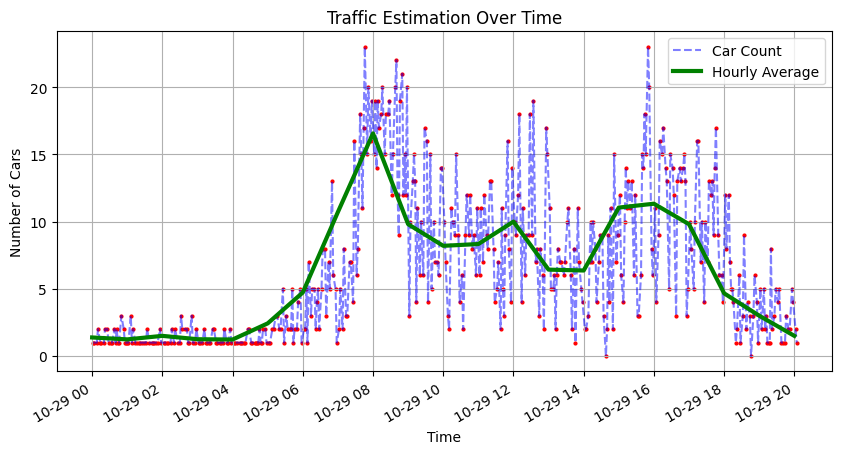

In [154]:
time_stamps = [
    datetime.strptime(string[8:-4], '%Y%m%d%H%M') for string in os.listdir(image_folder)
]


df = pd.DataFrame({'time': time_stamps, 
                   'num_cars': num_cars,
                   'image_paths': image_paths})
df.set_index('time', inplace=True)
df_hourly = df[['num_cars']].resample('h').mean().reset_index()


# Plotting the data
plt.figure(figsize=(10, 5))
plt.plot(df.index, df.num_cars, label='Car Count', color='blue', linestyle='dashed', alpha=0.5)
plt.scatter(df.index, df.num_cars, s=4, color='red')

plt.plot(df_hourly['time'], df_hourly['num_cars'], label='Hourly Average', color='green', lw=3)

# Formatting the x-axis for better readability
plt.gcf().autofmt_xdate()  # Auto formats dates for better display
plt.xlabel('Time')
plt.ylabel('Number of Cars')
plt.title('Traffic Estimation Over Time')
plt.grid(True)
plt.legend()
plt.show()


### Sampling images for annotation

For 2024-10-29 alone, there are 425 images. It would not be practical to sample every image. Moreover, adjacent images taken every two minutes look very similar. Instead, images will be randomly sampled every 30 minutes, reducing the number of images to label from 425 to 48.

Note: It could be more difficult to perform detection correctly during peak hours because the number of cars will be greater. Therefore, once enough data is obtained and peak times can be reasonably determined from the data across several days, sampling can be performed such that the occurrence of samples increases during peak hours.

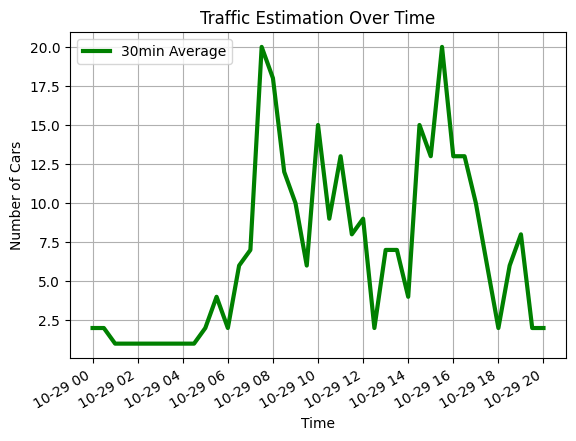

In [129]:
df_30min = df.resample('30min').apply(lambda x: x.sample(1, random_state=SEED)).reset_index()
plt.plot(df_30min['time'], df_30min['num_cars'], label='30min Average', color='green', lw=3)

# Formatting the x-axis for better readability
plt.gcf().autofmt_xdate()  # Auto formats dates for better display
plt.xlabel('Time')
plt.ylabel('Number of Cars')
plt.title('Traffic Estimation Over Time')
plt.grid(True)
plt.legend()
plt.show()

In [143]:
for path in df_30min['image_paths']:
    file_name = os.path.basename(path)
    annotate_path = os.path.join(annotate_folder, file_name)
    image=cv2.imread(path)
    cv2.imwrite(annotate_path, image)